# 1. Research statement and details
We want to know the answers for 2 related questions:
1. Can we use proximity graph cuts (PGC) to approximate class boundaries? If yes, which proximity graphs?
2. Can we build an instance-based classifiers using PGCs and how it overperforms classic approaches (kNN + techniques) in accuracy, speed and memory?

# 2. Datasets

We need to show that our methods work for different data: both low and highly dimensional, both small and big, both synthetic and real life, both noisy and clean:
1. Small low/high dimensional and big low/high dimensional clean synthetic dataset to justify that idea worth spending time (+4)
2. Small and big noisy datasets to see how noise influence the method (+4)
3. Small/big low/high dimensional real data dataset to see how the methods apply to real problems.

## 2.1. How the real dataset is distributed? Can we mimic?
Let's explore covtype dataset

In [1]:
import numpy as np

def read_to_numpy(path):
    X, y = np.zeros((581012, 54)),  []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            items = line.split()
            clas = items[0]
            pairs = [pair.split(':') for pair in items[1:]]
            for a, b in pairs:
                X[i, int(a) - 1] = float(b)
            y.append(clas)
    return X, y

X, y = read_to_numpy('../data/covtype/covtype.binary.scale')

X = np.nan_to_num(X)

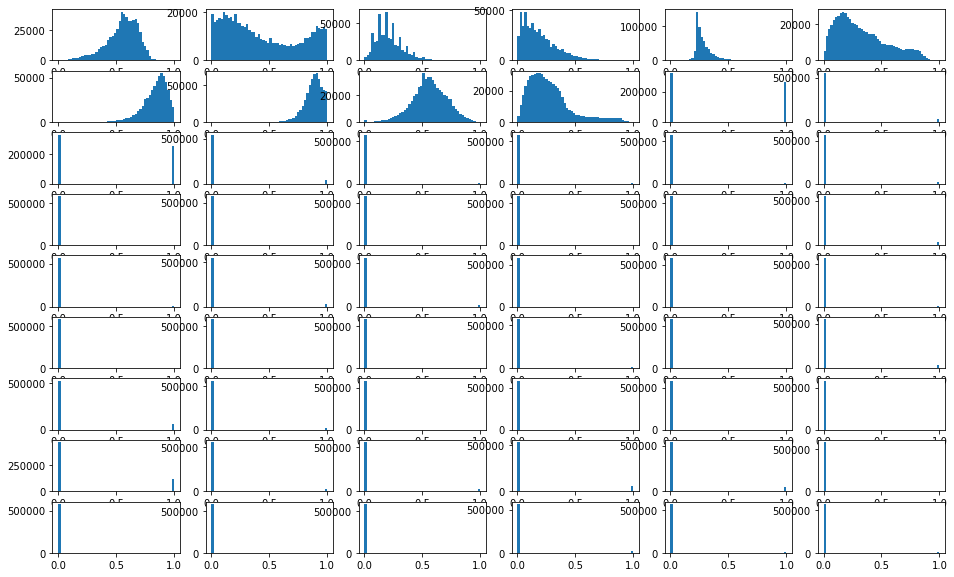

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 6, figsize=(16, 10))
for i in range(54):
    axs[i // 6, i % 6].hist(X[:, i], bins=50)

plt.show()

what about mutual feature distribution?

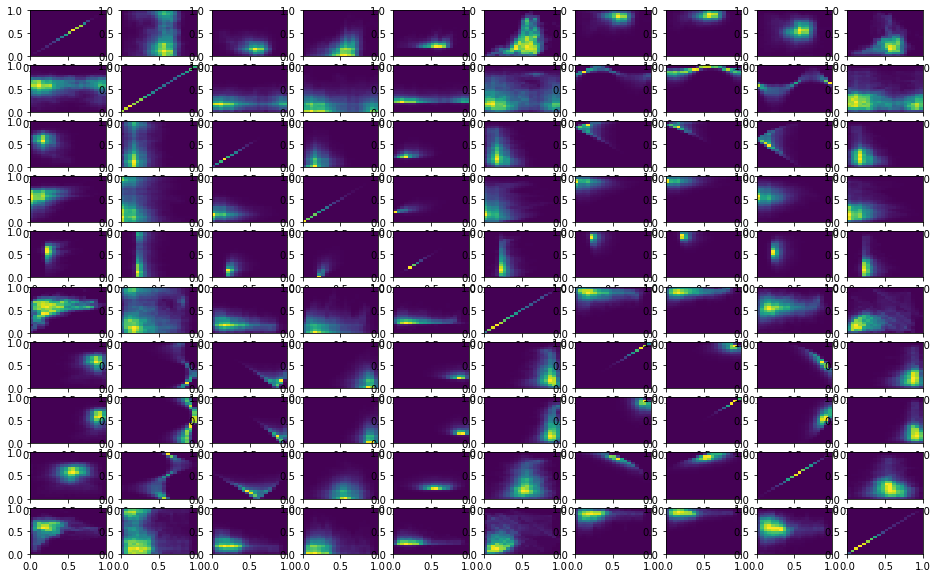

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(16, 10))
for i in range(10):
    for j in range(10):
        axs[i, j].hist2d(X[:, i], X[:, j], bins=20)

plt.show()

## 2.2. Can we use histogram to generate new data?

One way: to fit some distribution first. E.g. Dirichlet.

REF: https://tminka.github.io/papers/dirichlet/

```
@InProceedings{minka2000estimating,
author = {Minka, Tom},
title = {Estimating a Dirichlet Distribution},
year = {2000},
month = {September},
abstract = {The Dirichlet distribution and its compound variant, the Dirichlet-multinomial, are two of the most basic models for proportional data, such as the mix of vocabulary words in a text document. Yet the maximum-likelihood estimate of these distributions is not available in closed-form. This paper describes simple and efficient iterative schemes for obtaining parameter estimates in these models. In each case, a fixed-point iteration and a Newton-Raphson (or generalized Newton-Raphson) iteration is provided.},
url = {https://www.microsoft.com/en-us/research/publication/estimating-dirichlet-distribution/},
}
```

But to store a multivariate distribution of 54 dimensions we will run out of memory. This comes from the idea, that for pairwise correlations you need $bins^2$ for each pair, and for 54 dimensions we need $bins^{54}$, which for even 10 bins becomes enormously big value.

Many pairs of this dataset look like independent multivariate distributions. Thus we can generate few distributions for some features and then construct a multivariate generator.

What about feature correlation and covariation?

**Correlation** -- when expected value if Y depends on X value. Can be linear. If variance of Y depends on X, this is not correlation.

**Covariation** -- when independent variables rule $E(XY) = E(X)E(Y)$ fails. $cov(X,Y) = E(XY) - E(X)E(Y)$. The bigger is absolute value, the bigger is dependency. Covariance unit is squared unit of variables. We norm it by the spread to get *linear correlation coefficient*.

If linear correlation coefficient equals to 1/-1, then we have functional dependency. If it is 0, this doesn't mean independency -- they just don't *correlate*.

In [4]:
import pandas as pd
df = pd.DataFrame(X)

In [5]:
CX = df.corr()

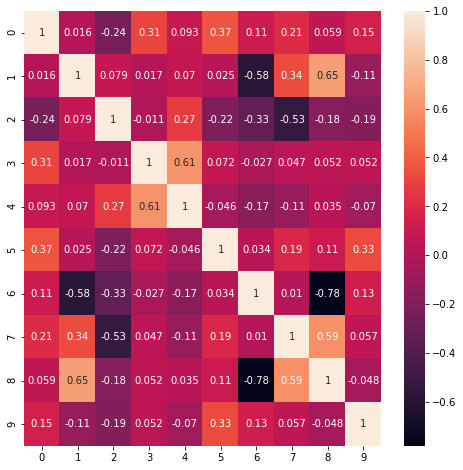

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt

CXA = np.array(CX)
plt.figure(figsize=(8, 8))
sn.heatmap(CXA[:10, :10], annot=True)
plt.show()

Some pairs show non-marginal correlation. TODO: and what?

Thanks to https://stackoverflow.com/a/63762024 for the loop

In [7]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=20)
while True: 
    try: 
        print("iteration")
        pca.fit(X)
        break 
    except: continue

iteration
iteration


In [8]:
sum(pca.explained_variance_ratio_)

0.8800448854431941

### 2.2.1. Generate a dataset with given list of histograms

Refer to https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

In [11]:
DATASET_SIZE = 50000

In [12]:
from scipy.stats import rv_histogram
def generate_by_hists(hists, N):
    result = np.zeros((N, len(hists)))
    for i, hist in enumerate(hists):
        distr = rv_histogram(hist)
        result[:, i] = distr.rvs(size=N)
    return result
        
np.random.seed(1234567)
hists = [np.histogram(X[:, col]) for col in range(X.shape[1])]
Xprime = generate_by_hists(hists, DATASET_SIZE)

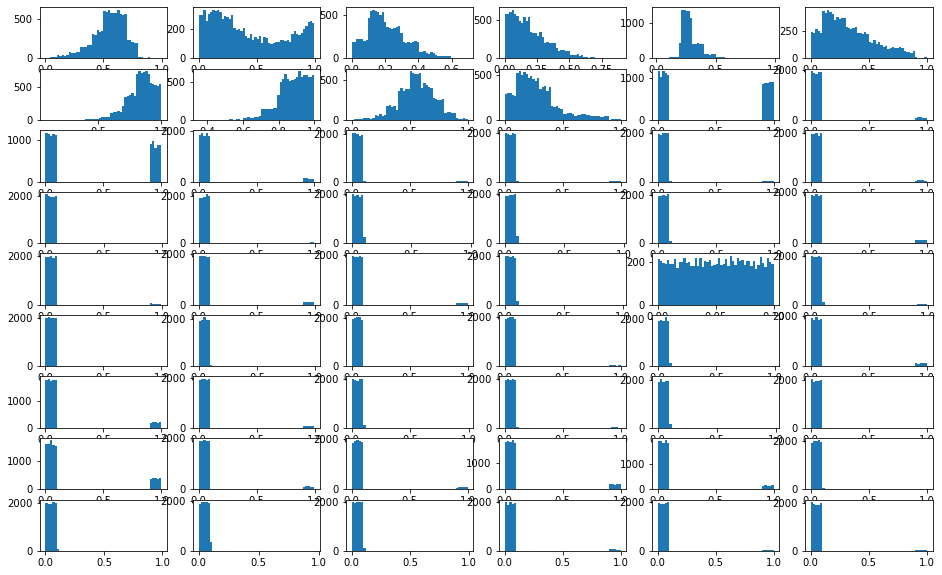

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 6, figsize=(16, 10))
for i in range(54):
    axs[i // 6, i % 6].hist(Xprime[:, i], bins=50)

plt.show()

2 features feels like spoiled (just 0-s in original hist).

# 2.3. Ok, how we create a class boundary?

We need a synthetic boundary, which allows us to easily compute distance from random point to it. Spherical is an interesting approach (TBD).

In [4]:
import numpy as np
from numpy.linalg import norm

def split_dataset_linearly(X):
    # find a mean point for each axis
    M = np.mean(X, axis=0)
    # any hyperplane through this point will split the data into 2 parts exactly
    np.random.seed(0)
    K = np.random.rand(X.shape[1], 1) * 2 - 1
    # we will use (X - M) dot K to decide a class
    Xc = (X - M) @ K    
    # whatever is higher than hyperplane is 1
    classes = (Xc > 0).flatten().astype(int)
    return classes, M, K

yprime, M, K = split_dataset_linearly(Xprime)
I = np.dot(M, K)[0] / norm(K)
sum(yprime), len(yprime) - sum(yprime)

(4949, 5051)

`K` here corresponds to decision plane coefficients. Same (but scaled) coefficients are produced by linear regression model.

`Intercept` will be a value of `Y` with `X=0`, in our case this is `(-M @ K)`.

Let's check that we created a linearly separable model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(Xprime, yprime, test_size=0.4, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2025
           1       0.96      0.96      0.96      1975

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



The report should show a linear classifier with very high accuracy value. So yes, we have a nice dataset.

In [6]:
from numpy.linalg import norm 

def signed_dist_to_plane(point, K, I):
    return np.dot(point, K)[0] / norm(K) - I

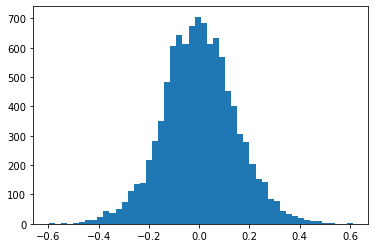

In [7]:
import matplotlib.pyplot as plt

dst = [signed_dist_to_plane(x, K, I) for x in Xprime]
plt.hist(dst, bins=50)
plt.show()

Ok we have a generated dataset and a tool to estimate a distance from arbitrary point to it's decision boundary.

# 3. Building a proximity graphs

We will build different proximity graphs for the given dataset. Our task is to measure:
% - *theoretical and measured build complexity for each of them
- space complexity for graph
- quality of border estimation with RMSE
- space complexity of graph cut

For experimental purposes we will stick to a medium-size dataset 10000 with items, which will make possible to complete construction of all graph types on a single machine.

In [5]:
import os
import networkx as nx
import time

def cached_graph(name, dataset, function):
    fname = f"../dumps/{name}-{len(dataset)}.pickle"
    if os.path.exists(fname):
        print("From cache", fname)
        graph = nx.read_gpickle(fname)
    else:
        print("Sorry, need to build from scratch")
        t = time.time()
        graph = function(dataset)
        t = time.time() - t
        print(f"Done in {t:.3} seconds")
        nx.write_gpickle(graph, fname)
    return graph

## 3.a. Complete graph

In [6]:
import numpy as np
import networkx as nx
import tqdm

def get_complete(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        for b in range(a + 1, len(dataset)):
            graph.add_edge(a, b, weight=dists[a, b])
    return graph

In [ ]:
cached_graph("complete", Xprime[:5000], get_complete)
cached_graph("complete", Xprime[:10000], get_complete)

Sorry, need to build from scratch


100%|██████████| 5000/5000 [00:31<00:00, 161.00it/s] 


Done in 32.9 seconds


## 3.b. Gabriel

In [13]:
import numpy as np
import networkx as nx
import bisect
from numba import jit
from numba import typed, types
import time

import tqdm

@jit
def get_gabriel_numba(dists, result):
    # result = typed.List()
    for a in range(len(dists)):
        for b in range(len(dists)):
            if a == b: continue
            ab = dists[a, b]
            is_gabriel = True
            for t in range(len(dists)):
                if a == t or b == t:
                    continue
                at = dists[a, t]
                tb = dists[t, b]
                if (at ** 2 + tb ** 2)  < ab ** 2:
                    is_gabriel = False
                    break
            if is_gabriel:
                l = typed.List.empty_list(types.int64, 2)
                l.append(a)
                l.append(b)
                result.append(l)
    return result


def get_gabriel_fast(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    small = typed.List()
    small.append(0)
    result = typed.List()
    result.append(small)
    result.pop()
    get_gabriel_numba(dists, result)
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    graph.add_weighted_edges_from([(kv[0], kv[1], dists[kv[0], kv[1]]) for kv in result])
    return graph
    

def get_gabriel(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        dist_idx = np.argsort(dists[a, :])
        for b in dist_idx:
            if a == b:
                continue
            ab = dists[a, b]
            first_greater = bisect.bisect_left(dists[a, dist_idx], ab)
            is_gabriel = True
            for t in dist_idx[:first_greater]:
                if a == t or b == t:
                    continue
                at = dists[a, t]
                tb = dists[t, b]
                if (at ** 2 + tb ** 2)  < ab ** 2:
                    is_gabriel = False
                    break
            if is_gabriel:
                graph.add_edge(a, b, weight=ab)
    
    return graph

In [16]:
cached_graph("gabriel", Xprime[:1000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:2000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:4000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:5000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:10000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:20000], get_gabriel_fast)
# cached_graph("gabriel", Xprime[:300000], get_gabriel_fast)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/gabriel-20000.pickle


## 3.c. Gabriel derivatives: RNG, NNG and EMST

- https://en.wikipedia.org/wiki/Euclidean_minimum_spanning_tree
- https://github.com/AndrewB330/EuclideanMST

In [18]:
def get_nng_from_gabriel(graph):
    nng = nx.DiGraph()
    nng.add_nodes_from(graph.nodes)
    for node in graph.nodes:
        m, i = None, None
        for nn, w in graph[node].items():
            if m is None or w['weight'] < m:
                i = nn
                m = w['weight']
        nng.add_edge(node, i, weight=m)
    return nng


def get_rng_from_gabriel(graph):
    ''' 
    As RNG is a subset of a Gabriel graph, thus we can construct one of 
    another by examining existing neighbourhoods: we test existing edge ends
    for having a shared neighbour with smaller distance
    '''
    rng = nx.Graph()
    rng.add_nodes_from(graph.nodes)
    for src, dst, w in graph.edges.data("weight", default=None):
        intersect = set.intersection(set(graph.neighbors(src)), set(graph.neighbors(dst)))
        keep = True
        for transit in intersect:
            if w > graph[src][transit]['weight'] and w > graph[dst][transit]['weight']:
                keep = False
                break
        if keep:
            rng.add_edge(src, dst, weight=w)
    return rng


def get_emst(graph):
    emst = nx.minimum_spanning_tree(graph)
    return emst

In [22]:
cached_graph("nng", cached_graph("gabriel", Xprime[:1000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:2000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:4000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:5000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:10000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:20000], get_gabriel_fast), get_nng_from_gabriel)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/nng-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/nng-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/nng-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/nng-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/nng-10000.pickle
From cache ../dumps/gabriel-20000.pickle
From cache ../dumps/nng-20000.pickle


In [24]:
cached_graph("rng", cached_graph("gabriel", Xprime[:1000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:2000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:4000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:5000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:10000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:20000], get_gabriel_fast), get_rng_from_gabriel)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/rng-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/rng-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/rng-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/rng-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/rng-10000.pickle
From cache ../dumps/gabriel-20000.pickle
From cache ../dumps/rng-20000.pickle


In [26]:
cached_graph("emst", cached_graph("gabriel", Xprime[:1000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:2000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:4000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:5000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:10000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:20000], get_gabriel_fast), get_emst)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/emst-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/emst-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/emst-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/emst-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/emst-10000.pickle
From cache ../dumps/gabriel-20000.pickle
From cache ../dumps/emst-20000.pickle


## 3.1. NSW

In [15]:
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph

G = NSWGraph()

In [16]:
G = NSWGraph()
data_sample = [(x, y) for x, y in zip(Xprime[:1000], yprime[:1000])]
G.build_navigable_graph(data_sample)

import networkx as nx



## 3.2. Radius NG with BallTree

sci-kit learn uses BallTree data structure to build proximity graph. Thus, thee construction is the essential part of algorithm.
But when in comes to $D > 15$, they use just a brute force technique.

### Ball Tree construction 
itself is enournously fast, as it guarantees log time search for low dimensions.

In [17]:
from sklearn.neighbors import BallTree
import time

### Currently, algorithm = 'auto' selects 'brute' if any of the following conditions are verified
### when D > 15, the intrinsic dimensionality of the data is generally too high for tree-based methods
print("data\tleaf s.\tconstr. time\tdatashape")
for datasetsize in [1000, 10000, 50000, 100000, 200000]:
    for ls in [1, 10, 50, 100]:
        start = time.time()
        bt = BallTree(Xprime[:datasetsize], leaf_size=ls)
        t = time.time() - start
        print(f'{datasetsize}\t{ls}\t{t:1.6}\t{bt.data.shape}') 

data	leaf s.	constr. time	datashape
1000	1	0.0039959	(1000, 54)
1000	10	0.00199676	(1000, 54)
1000	50	0.000999451	(1000, 54)
1000	100	0.000998974	(1000, 54)
10000	1	0.0499992	(10000, 54)
10000	10	0.0339997	(10000, 54)
10000	50	0.0199995	(10000, 54)
10000	100	0.0190008	(10000, 54)
50000	1	0.351998	(50000, 54)
50000	10	0.301523	(50000, 54)
50000	50	0.227529	(50000, 54)
50000	100	0.237997	(50000, 54)
100000	1	0.858992	(100000, 54)
100000	10	0.677995	(100000, 54)
100000	50	0.568524	(100000, 54)
100000	100	0.632071	(100000, 54)
200000	1	1.06851	(100000, 54)
200000	10	0.765993	(100000, 54)
200000	50	0.613995	(100000, 54)
200000	100	0.536994	(100000, 54)


links:
- https://scikit-learn.org/stable/modules/neighbors.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.radius_neighbors_graph.html#sklearn.neighbors.radius_neighbors_graph
- http://ftp.icsi.berkeley.edu/ftp/pub/techreports/1989/tr-89-063.pdf - BallTree is used as a default approach for NN search queries
- http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.91.8209

So here we can observe, that using BallTree or brute force does not affect the quality (`True` values to the right mean the algorithms return excactly the same result). But bring valuable 

In [18]:
from sklearn.neighbors import radius_neighbors_graph
import time
from collections import Counter

# do tests on sizes, times
rads = [0.1, 0.5, 1, 5]
sizes = [100, 1000, 2000, 4000, 6000, 8000, 10000]
jobs = [1, 2, 4]

times_brute = np.zeros((len(rads), len(sizes), len(jobs)))
times_ball = np.zeros((len(rads), len(sizes), len(jobs)))
degrees = np.zeros((len(rads), len(sizes), len(jobs)))

for i, radius in enumerate(rads):
    for j, datasetsize in enumerate(sizes):
        for k, njobs in enumerate(jobs):
            
            start = time.time()
            rNG_B = radius_neighbors_graph(Xprime[:datasetsize], radius=radius, n_jobs=njobs)
            t0 = time.time() - start
            
            graphdegree0 = len(rNG_B.nonzero()[0])
            print(f'{njobs}\t{datasetsize}\t{radius}\t{t0}\t{graphdegree0}\t', end="")
            
            start = time.time()
            bt = BallTree(Xprime[:datasetsize])
            rNG_T = radius_neighbors_graph(bt, radius=radius, n_jobs=njobs)
            t1 = time.time() - start
            graphdegree1 = len(rNG_T.nonzero()[0])
            tst = np.allclose(rNG_B.toarray(), rNG_T.toarray())
            
            print(f'{njobs}\t\t{t1}\t{graphdegree1}\t{tst}')
            
            times_brute[i, j, k] = t0 
            times_ball[i, j, k] = t1 
            degrees[i, j, k] = graphdegree1

1	100	0.1	0.0029973983764648438	0	1		0.015996932983398438	0	True
2	100	0.1	0.021003007888793945	0	2		0.0040013790130615234	0	True
4	100	0.1	0.006005048751831055	0	4		0.006001710891723633	0	True
1	1000	0.1	0.17699599266052246	0	1		0.05200052261352539	0	True
2	1000	0.1	0.10599899291992188	0	2		0.04000234603881836	0	True
4	1000	0.1	0.06199789047241211	0	4		0.029000043869018555	0	True
1	2000	0.1	0.5489940643310547	0	1		0.21100139617919922	0	True
2	2000	0.1	0.3079991340637207	0	2		0.1419963836669922	0	True
4	2000	0.1	0.21799778938293457	0	4		0.10499906539916992	0	True
1	4000	0.1	1.6984970569610596	0	1		0.7989919185638428	0	True
2	4000	0.1	1.048987865447998	0	2		0.5809931755065918	0	True
4	4000	0.1	0.665999174118042	0	4		0.5559902191162109	0	True
1	6000	0.1	3.247485876083374	0	1		3.3784894943237305	0	True
2	6000	0.1	2.1380181312561035	0	2		1.1215145587921143	0	True
4	6000	0.1	1.1369895935058594	0	4		0.8589928150177002	0	True
1	8000	0.1	7.041446685791016	0	1		3.8610289096832275	0	True
2	8000	

KeyboardInterrupt: 

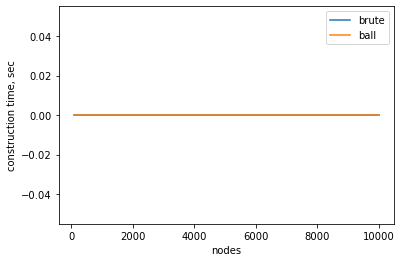

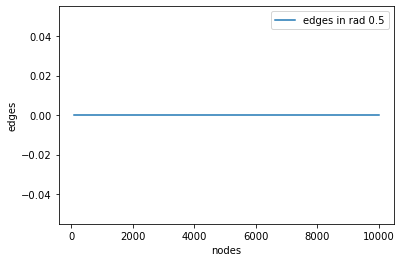

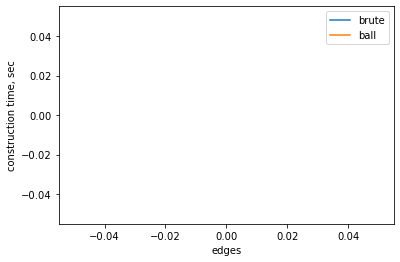

In [19]:
# rad 0.5, 4 threads
plt.plot(sizes, times_brute[2, :, 2], label="brute")
plt.plot(sizes, times_ball[2, :, 2], label="ball")
plt.xlabel("nodes")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

plt.plot(sizes, degrees[2, :, 2], label="edges in rad 0.5")
plt.xlabel("nodes")
plt.ylabel("edges")
plt.legend()
plt.show()

# rad 0.5, 4 threads
plt.plot(degrees[2, :, 2], times_brute[2, :, 2], label="brute")
plt.plot(degrees[2, :, 2], times_ball[2, :, 2], label="ball")
plt.xlabel("edges")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

Looks like a polynomial construction time for both nodes and edges

## 3.2. k-NN graph with BallTree
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

In [ ]:
# from sklearn.neighbors import kneighbors_graph

# for n in [1, 2, 5, 10, 20, 50, 100]:
#     for datasetsize in [1000, 10000, 20000, 40000]:
#             start = time.time()
#             kNN = kneighbors_graph(Xprime[:datasetsize], n_neighbors=n)
#             t = time.time() - start
#             graphdegree = len(kNN.nonzero()[0])
#             # spread = Counter(rNG.nonzero()[0])
#             # print(spread.most_common(10))
#             print(f'{datasetsize}\t{n}\t{t}\t{graphdegree}') 

In [20]:
from sklearn.neighbors import kneighbors_graph
import time
from collections import Counter

# do tests on sizes, times
ns_k = [1, 2, 5, 10, 20, 50, 100]
sizes_k = [1000, 2000, 3000, 4000, 5000, 8000, 10000]
jobs_k = [1, 2, 4]

times_brute_k = np.zeros((len(ns_k), len(sizes_k), len(jobs_k)))
times_ball_k = np.zeros((len(ns_k), len(sizes_k), len(jobs_k)))
degrees_k = np.zeros((len(ns_k), len(sizes_k), len(jobs_k)))

for i, n in enumerate(ns_k):
    for j, datasetsize in enumerate(sizes_k):
        for k, njobs in enumerate(jobs_k):
            
            start = time.time()
            kNN_B = kneighbors_graph(Xprime[:datasetsize], n_neighbors=n, n_jobs=njobs)
            t0 = time.time() - start
            
            graphdegree0 = len(kNN_B.nonzero()[0])
            print(f'{njobs}\t{datasetsize}\t{n}\t{t0}\t{graphdegree0}\t', end="")
            
            start = time.time()
            bt = BallTree(Xprime[:datasetsize])
            kNN_T = kneighbors_graph(bt, n_neighbors=n, n_jobs=njobs)
            t1 = time.time() - start
            graphdegree1 = len(kNN_T.nonzero()[0])
            tst = np.allclose(kNN_B.toarray(), kNN_T.toarray())
            
            print(f'{njobs}\t\t{t1}\t{graphdegree1}\t{tst}')
            
            times_brute_k[i, j, k] = t0 
            times_ball_k[i, j, k] = t1 
            degrees_k[i, j, k] = graphdegree1

1	1000	1	0.2719249725341797	1000	1		0.10702919960021973	1000	True
2	1000	1	0.15599536895751953	1000	2		0.04200315475463867	1000	True
4	1000	1	0.03600192070007324	1000	4		0.026001930236816406	1000	True
1	2000	1	0.3139955997467041	2000	1		0.2270035743713379	2000	True
2	2000	1	0.18999314308166504	2000	2		0.15799784660339355	2000	True
4	2000	1	0.1510012149810791	2000	4		0.13700008392333984	2000	True
1	3000	1	0.7240025997161865	3000	1		0.5599918365478516	3000	True
2	3000	1	0.3269970417022705	3000	2		0.3900020122528076	3000	True
4	3000	1	0.22899746894836426	3000	4		0.2280113697052002	3000	True
1	4000	1	0.9159936904907227	4000	1		0.8730545043945312	4000	True
2	4000	1	0.5209951400756836	4000	2		0.6169979572296143	4000	True
4	4000	1	0.41600918769836426	4000	4		0.6899900436401367	4000	True
1	5000	1	1.318202018737793	5000	1		1.6099860668182373	5000	True
2	5000	1	1.1419897079467773	5000	2		0.9129946231842041	5000	True
4	5000	1	0.505993127822876	5000	4		0.7019920349121094	5000	True
1	8000	1	4.53698

KeyboardInterrupt: 

In [ ]:
# n = 100, 4 threads
plt.plot(sizes, times_brute_k[6, :, 2], label="brute")
plt.plot(sizes, times_ball_k[6, :, 2], label="ball")
plt.xlabel("nodes")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

plt.plot(sizes, degrees_k[6, :, 2], label="edges in n = 100")
plt.xlabel("nodes")
plt.ylabel("edges")
plt.legend()
plt.show()

# n = 20, 4 threads
plt.plot(sizes, times_brute_k[4, :, 2], label="brute")
plt.plot(sizes, times_ball_k[4, :, 2], label="ball")
plt.xlabel("nodes")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

plt.plot(sizes, degrees_k[4, :, 2], label="edges in n = 20")
plt.xlabel("nodes")
plt.ylabel("edges")
plt.legend()
plt.show()

# GET CUT

In [ ]:
def get_cut(graph, labels):
    return [e for e in graph.edges.data("weight", default=None) if labels[e[0]] != labels[e[1]]]